In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["erddapy", "palettable"]
_colab_install_missing_deps(deps)

# erddapy: a python client/URL builder for ERDDAP

Created: 2018-03-01

Updated: 2026-02-02

ERDDAP has RESTful API that is very convenient for creating web apps, data portals, etc. However, writing those URLs manually can be tedious and error prone

This notebook walks through an easy to set up ERDDAP RESTful URL by using the python client, `erddapy`.

A typical [ERDDAP RESTful URL]((https://gliders.ioos.us/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time%3E=2016-07-10T00:00:00Z&time%3C=2017-02-10T00:00:00Z&latitude%3E=38.0&latitude%3C=41.0&longitude%3E=-72.0&longitude%3C=-69.0)) looks like:

- base: `https://gliders.ioos.us/gliders/erddap/`
  protocol: `tabledap/`
  dataset_id: `whoi_406-20160902T1700.mat?`
- variables: `depth,latitude,longitude,salinity,temperature,time`
- constraints: `&time>=2016-07-10T00:00:00Z&time<=2017-0210T00:00:00Z&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0`

Let's break it down to smaller parts:

- **server**: https://gliders.ioos.us/erddap/index.html
- **protocol**: tabledap
- **dataset_id**: whoi_406-20160902T1700
- **response**: .mat
- **variables**: depth,latitude,longitude,temperature,time
- **constraints**:
  - time>=2016-07-10T00:00:00Z
  - time\<=2017-02-10T00:00:00Z
  - latitude>=38.0
  - latitude\<=41.0
  - longitude>=-72.0
  - longitude\<=-69.0

We can represent that easily in Python like in the cell below.

Feeding these variables in the `erddapy.ERDDAP` class we will create the URL builder object.

In [2]:
server = "https://gliders.ioos.us/erddap/"

protocol = "tabledap"

dataset_id = "whoi_406-20160902T1700"

response = "mat"

variables = [
    "depth",
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
]

constraints = {
    "time>=": "2016-07-10T00:00:00Z",
    "time<=": "2017-02-10T00:00:00Z",
    "latitude>=": 38.0,
    "latitude<=": 41.0,
    "longitude>=": -72.0,
    "longitude<=": -69.0,
}

In [3]:
from erddapy import ERDDAP

e = ERDDAP(
    server=server,
    protocol=protocol,
)


e.dataset_id = dataset_id
e.variables = variables
e.constraints = constraints

print(e.get_download_url())

https://gliders.ioos.us/erddap/tabledap/whoi_406-20160902T1700.html?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


If we change the response to `html` we can visualize the page.

![2018-03-01-erddapy-iframe-0.png](https://raw.githubusercontent.com/ioos/ioos_code_lab/main/jupyterbook/content/code_gallery/data_access_notebooks/2018-03-01-erddapy-iframe-0.png)

Additionally, the object has `.get_info_url()` and `.get_search_url()` that can be used to obtain the info and search URLs respectively

In [4]:
print(e.get_info_url(response="html"))

https://gliders.ioos.us/erddap/info/whoi_406-20160902T1700/index.html


In [5]:
print(e.get_search_url(response="html"))

https://gliders.ioos.us/erddap/search/advanced.html?page=1&itemsPerPage=1000000&protocol=tabledap&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=(ANY)&variableName=(ANY)&minLon=(ANY)&maxLon=(ANY)&minLat=(ANY)&maxLat=(ANY)&minTime=&maxTime=


`erddapy` also brings some simple methods to download the data in some common data formats, like `pandas.DataFrame` and `xarray.Dataset`.

In [6]:
df = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
).dropna()


df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-03 20:15:46+00:00,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46+00:00,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46+00:00,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46+00:00,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46+00:00,8.43,40.990881,-71.12439,32.224503,20.5691


In [7]:
ds = e.to_xarray(decode_times=False)

ds["temperature"]

<xarray.DataArray 'temperature' (obs: 48920)> Size: 196kB
[48920 values with dtype=float32]
Coordinates:
    depth    (obs) float32 196kB ...
Dimensions without coordinates: obs
Attributes: (12/14)
    _ChunkSizes:          106
    actual_range:         [ 9.9473 22.6177]
    ancillary_variables:  qartod_temperature_climatological_flag qartod_tempe...
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    instrument:           instrument_ctd
    ...                   ...
    observation_type:     measured
    platform:             platform
    standard_name:        sea_water_temperature
    units:                Celsius
    valid_max:            40.0
    valid_min:            -5.0

Here is a simple plot using the data from `xarray`.

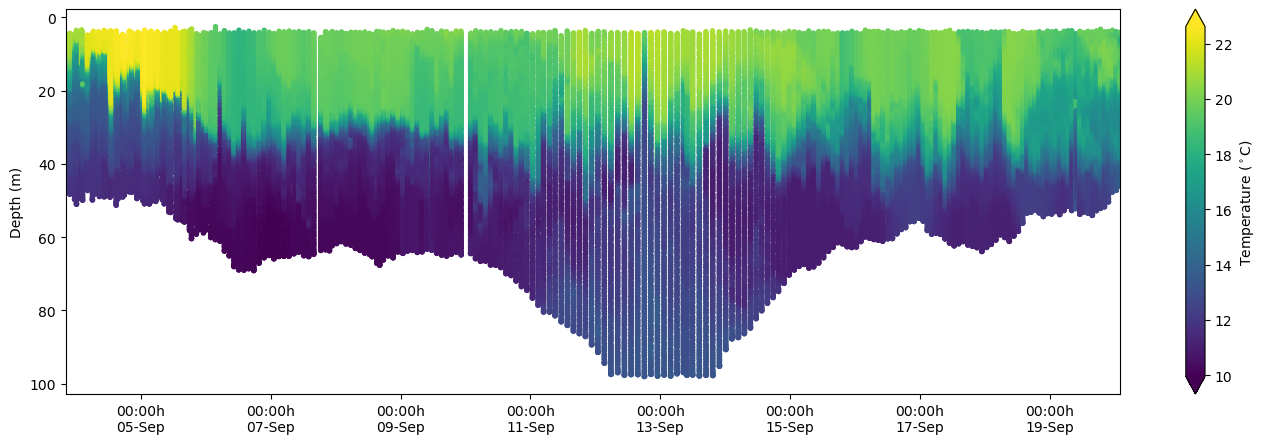

In [8]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=15, c=df["temperature (Celsius)"], marker="o", edgecolor="none")
cs = ax.scatter(df.index, df["depth (m)"], **kw)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation="vertical", extend="both")
cbar.ax.set_ylabel(r"Temperature ($^\circ$C)")
ax.set_ylabel("Depth (m)");

One can build the proper variables programmatically, feed them in erddapy, and then build a service like [this notebook](https://github.com/ioos/BioData-Training-Workshop/blob/main/notebooks/ERDDAP_timeseries_explorer-IOOS.ipynb). However, erddapy is also designed for interactive work. One can explore interactively the ERDDAP server from Python.

PS: Note that in this example below we did not feed any variables other than the server URL

In [9]:
import pandas as pd
from erddapy import ERDDAP

e = ERDDAP(server="https://gliders.ioos.us/erddap/")

df = pd.read_csv(e.get_search_url(response="csv", search_for="all"))

In [10]:
"We have {} tabledap, {} griddap, and {} wms endpoints.".format(
    len(set(df["tabledap"].dropna())),
    len(set(df["griddap"].dropna())),
    len(set(df["wms"].dropna())),
)

'We have 2401 tabledap, 0 griddap, and 0 wms endpoints.'

We can refine our search by adding some constraints.

In [11]:
kw = {
    "standard_name": "sea_water_temperature",
    "min_lon": -72.0,
    "max_lon": -69.0,
    "min_lat": 38.0,
    "max_lat": 41.0,
    "min_time": "2016-07-10T00:00:00Z",
    "max_time": "2017-02-10T00:00:00Z",
    "cdm_data_type": "trajectoryprofile",
}

In [12]:
search_url = e.get_search_url(response="csv", **kw)
search = pd.read_csv(search_url)
gliders = search["Dataset ID"].values

joined = "\n".join(gliders)
print(f"Found {len(gliders)} Glider Datasets:\n\n{joined}")

Found 19 Glider Datasets:

blue-20160818T1448
cp_335-20170116T1459-delayed
cp_336-20160809T1354-delayed
cp_336-20161011T0058-delayed
cp_336-20170116T1254-delayed
cp_339-20170116T2353-delayed
cp_340-20160809T0621-delayed
cp_374-20140416T1634-delayed
cp_374-20150509T1256-delayed
cp_374-20160529T0026-delayed
cp_376-20160527T2050-delayed
cp_380-20161011T2046-delayed
cp_387-20160404T1858-delayed
cp_388-20160809T1406-delayed
cp_388-20170116T1324-delayed
cp_389-20161011T2040-delayed
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


Last but not least we can inspect a specific `dataset_id`.

In [13]:
info_url = e.get_info_url(dataset_id=gliders[0], response="csv")
info = pd.read_csv(info_url)

info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgement,String,This deployment supported by NOAA U.S. IOOS
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"time_uv,lat_uv,lon_uv,u,v,profile_id,time,lati..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory,wmo_id"
4,attribute,NC_GLOBAL,comment,String,Glider deployed by the University of Massachus...


With the info URL we can filter the data using attributes.

In [14]:
cdm_profile_variables = info.loc[
    info["Attribute Name"] == "cdm_profile_variables", "Variable Name"
]

print("".join(cdm_profile_variables))

NC_GLOBAL


In fact, that is such a common operation that `erddapy` brings its own method for filtering data by attributes. In the next three cells we request the variables names that has a `cdm_profile_variables`, a `standard_name` of `sea_water_temperature`, and an axis respectively.

In [15]:
e.get_var_by_attr(
    dataset_id=gliders[0],
    cdm_profile_variables=lambda v: v is not None,
)

['NC_GLOBAL']

In [16]:
e.get_var_by_attr(
    dataset_id="whoi_406-20160902T1700",
    standard_name="sea_water_temperature",
)

['temperature']

In [17]:
axis = e.get_var_by_attr(
    dataset_id="whoi_406-20160902T1700",
    axis=lambda v: v in ["X", "Y", "Z", "T"],
)
axis

['longitude', 'latitude', 'depth', 'time']

With this method one can, for example, request data from multiple datasets using the standard_name.

In [18]:
def get_cf_vars(
    e,
    dataset_id,
    standard_names=["sea_water_temperature", "sea_water_practical_salinity"],
):
    """Return the axis of a dataset_id the variable with the `standard_name`."""
    variables = e.get_var_by_attr(
        dataset_id=dataset_id, axis=lambda v: v in ["X", "Y", "Z", "T"]
    )
    if len(variables) < 4:
        raise Exception(f"Expected at least 4 axis, found {variables!r}")

    var = e.get_var_by_attr(
        dataset_id=dataset_id, standard_name=lambda v: v in standard_names
    )
    if len(var) > 2:
        raise Exception(
            f"Found more than 1 variable with `standard_names` {standard_names}\n{var!r}"
        )
    variables.extend(var)
    return variables

In [19]:
import time

from erddapy.core.url import urlopen


def download_csv(url):
    return pd.read_csv(urlopen(url), index_col="time", parse_dates=True, skiprows=[1])


standard_names = ["sea_water_temperature", "sea_water_practical_salinity"]
variables = get_cf_vars(
    e,
    dataset_id=gliders[0],
    standard_names=standard_names,
)


dfs = {}
for glider in gliders:
    download_url = e.get_download_url(
        dataset_id=glider,
        protocol="tabledap",
        variables=variables,
        response="csv",
        constraints=constraints,
    )
    try:
        df = download_csv(download_url)
        time.sleep(3)  # Sleep for 3 seconds so we are not kicked out of that server.
    except Exception as err:
        print(f"Could not download {glider}\n{err}")
        continue
    dfs.update({glider: df})

Could not download silbo-20160413T1534
Error {
    code=404;
    message="Not Found: Your query produced no matching results. (nRows = 0)";
}

Could not download sp022-20170209T1616
Error {
    code=404;
    message="Not Found: Your query produced no matching results. (nRows = 0)";
}



To close this notebook, let's plot the tracks and a TS diagram for all the gliders found in that search.

In [20]:
k = 0
tiles = (
    "http://services.arcgisonline.com/arcgis/rest/services/"
    "World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}"
)


def plot_track(df, name, color="orange"):
    df = df.reset_index().drop_duplicates("time", keep="first").sort_values("time")
    locations = list(zip(df["latitude"].values, df["longitude"].values))

    folium.PolyLine(
        locations=locations,
        color=color,
        weight=8,
        opacity=0.7,
        tooltip=name,
        popup=name,
    ).add_to(m)

In [21]:
from palettable import cubehelix

colors = cubehelix.Cubehelix.make(
    n=len(dfs),
    start_hue=240,
    end_hue=-300,
    min_sat=1,
    max_sat=2.5,
    min_light=0.3,
    max_light=0.8,
    gamma=0.9,
).hex_colors

In [22]:
import folium

m = folium.Map(location=(40.3052, -70.8833), zoom_start=7, tiles=tiles, attr="ESRI")

for name, df in list(dfs.items()):
    plot_track(df, name, color=colors[k])
    k += 1

m

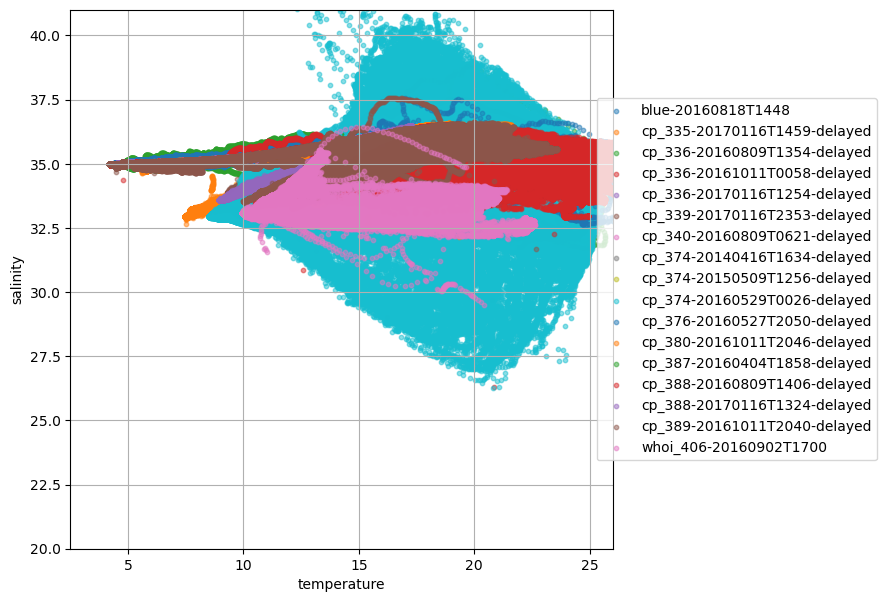

In [23]:
def glider_scatter(df, ax, glider):
    ax.scatter(df["temperature"], df["salinity"], s=10, alpha=0.5, label=glider)


fig, ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel("salinity")
ax.set_xlabel("temperature")
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)
ax.set_ylim(20, 41)
ax.set_xlim(2.5, 26)

ax.legend(bbox_to_anchor=(1.5, 0.5), loc="right");